# Разработка стратегии  взаимодействия с пользователями на основе аналитических данных для сети фитнес-центров «Культурист-датасаентист»

# Оглавление <a name="шаг-0"></a>
   [Введение](#0)
   
1. [Шаг 1. Загрузка данных](#1)

2. [Шаг 2. Проведение исследовательского анализа данных (EDA)](#2)
    
3. [Шаг 3. Построение модели прогнозирования оттока пользователей](#3)
    
4. [Шаг 4. Кластеризация пользователей](#4)
    
5. [Шаг 5. Формулировка выводов и создание базовых рекомендаций по работе с клиентами](#5)   

# Введение
**Цель исследования:** Провести анализ и подготовить план действий по удержанию клиентов на основе анкетирования пользователей

**Описание требований:** 

    •	научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    •	сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    •	проанализировать основные признаки, наиболее сильно влияющие на отток;
    •	сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
       	1) выделить целевые группы клиентов;
       	2) предложить меры по снижению оттока;
       	3) определить другие особенности взаимодействия с клиентами.


**Данные для анализа:**
  
Датасет gym_churn.csv содержит:

    - 'Churn' — факт оттока в текущем месяце;
    - 'gender' — пол
    - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
    - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
    - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
    - 'Phone' — наличие контактного телефона
    - 'Age' — возраст
    - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
    - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
    - 'Group_visits' — факт посещения групповых занятий
    - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
    - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
    - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон



# Шаг 1. Загрузка данных  <a name="1"></a>

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage 
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")


In [55]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

In [56]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [57]:
gym_churn.columns = [col.lower() for col in gym_churn.columns] #замена заглавных букв с помощью list comprehansion

In [58]:
gym_churn.sample(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3871,0,1,1,1,0,1,0,31,127.801732,1.0,3,2.632902,2.705422,0
3827,0,0,0,0,1,1,0,25,194.224420,1.0,0,1.266566,0.552702,1
674,0,1,0,0,1,1,0,26,134.173695,1.0,0,2.362800,2.323650,1
3454,1,1,0,0,1,12,1,34,22.801101,10.0,2,3.391320,3.316116,0
2745,0,1,1,1,1,1,0,27,136.221354,1.0,11,0.834244,0.715078,0


In [59]:
gym_churn.duplicated().sum()

0

# Выводы:
- Данные содержат 4 тыс.строк без пропущенных значений.
- Названия столбцов переведены в строчный формат.
- Категориальные признаки отстутствуют, следовательно нет необходимости в преобразованиях. 
- Типы значений корректны.
- Дубликаты отстутствуют.

 [Вернуться к оглавлению](#шаг-0)

# Шаг 2. Проведение исследовательского анализа данных (EDA) <a name="2"></a>

In [60]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [61]:
gym_churn.groupby(['churn'])['churn'].count()

churn
0    2939
1    1061
Name: churn, dtype: int64

На основе анализа общих статитстических данных сделаны предварительные выводы:
   - зал посещает практически одинаковое количество женщин и мужчин;
   - большинство посетителей живут поблизости от фитнес-центра;
   - половина посетителей являются сотрудниками компаний-патрнеров;
   - только треть посетивших зал впервые воспользовались промо-кодом;
   - 90% пользователей оставили в анкетных данных свой телефон;
   - популярная длительность приобретаемого абонемента составляет 1 месяц;
   - пользователи посещают групповые занятия в 40% случаев;
   - возраст посетителей фитнес-клуба от 18 до 41 года, где и медианное и среднее значения  возраста  - 29 лет;
   - посетители чаще всего не выходят за рамки оплаченной абон.платы при принятии решения о покупке дополнительных услуг;
   - для фитнес-центра характерен очень короткий период lifiteme - времени с момента превого обращения: 1-3 месяца для большинства посетителей;
   - посетители посещают клуб 1-2 раза в неделю;
   - отток составляет 26%.

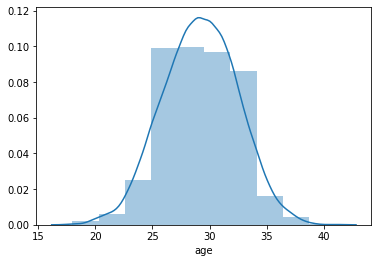

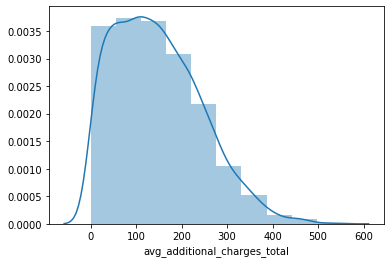

In [62]:
#Распределение до стандартизации:
sns.distplot(gym_churn['age'], bins = 10)
plt.show() 
sns.distplot(gym_churn['avg_additional_charges_total'], bins = 10)
plt.show() 

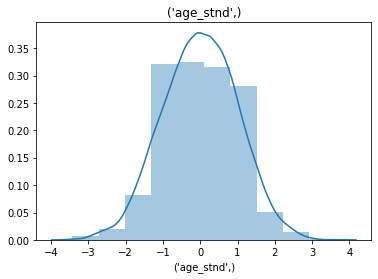

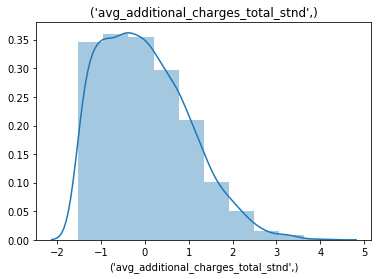

In [63]:
#стандартизация и новые данные

scaler = StandardScaler()  
scaler.fit(gym_churn[['age',
               'avg_additional_charges_total']])
X_sc = scaler.transform(gym_churn[['age',
               'avg_additional_charges_total']])  
gym_churn_new = pd.DataFrame(data = X_sc, columns = [['age_stnd',
               'avg_additional_charges_total_stnd']])
for feature in gym_churn_new.columns:
    sns.distplot(gym_churn_new[feature], bins = 10)
    plt.title(feature)
    plt.show() 

# Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

In [64]:
gym=gym_churn.groupby('churn').mean()
gym = np.transpose(gym) #транспонируем таблицу для лучшей визуализации
gym

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


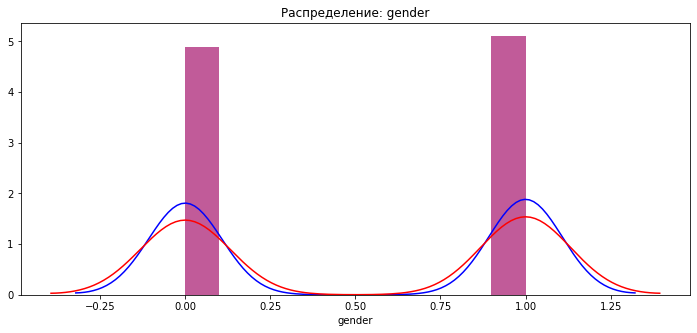

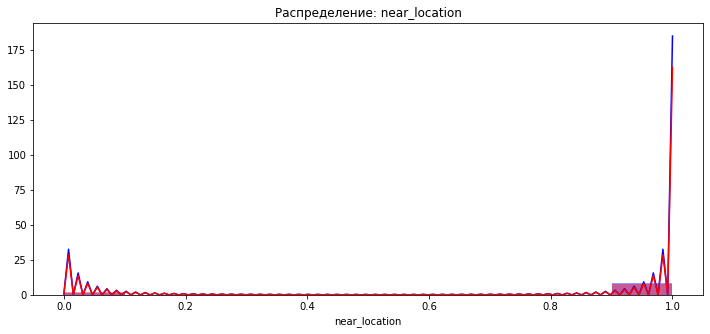

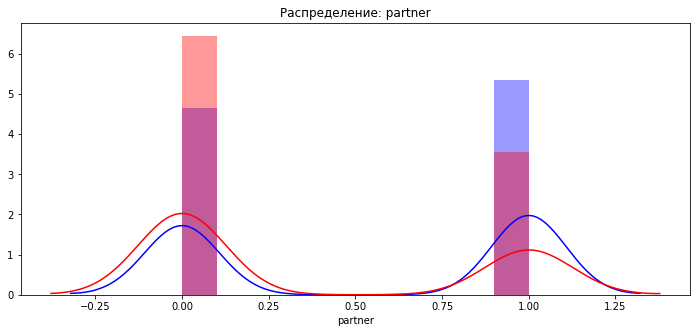

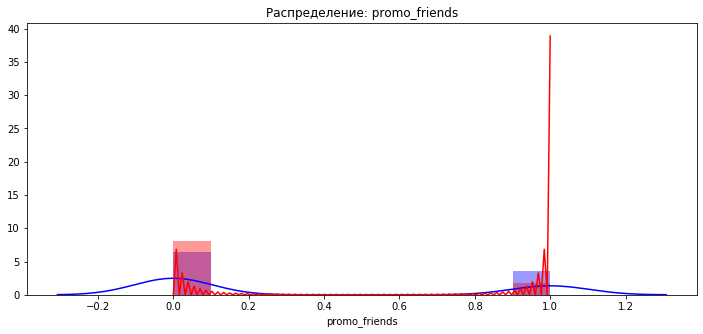

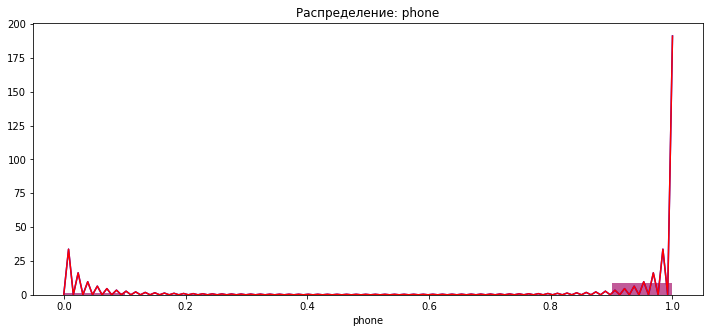

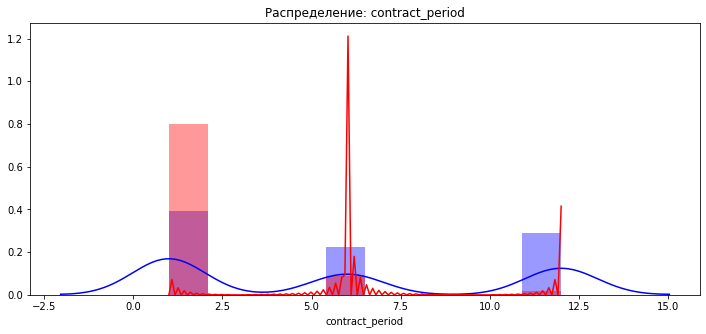

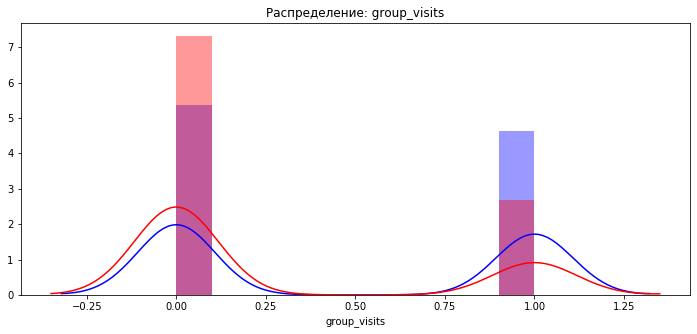

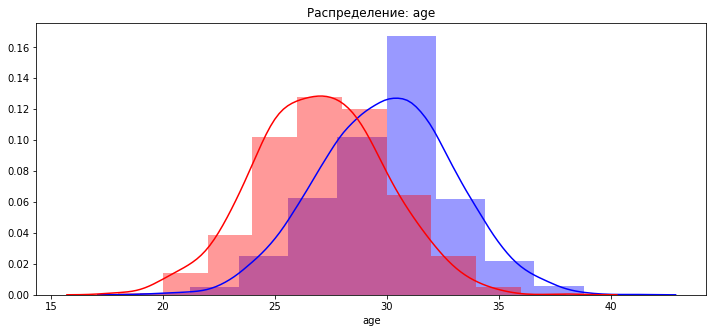

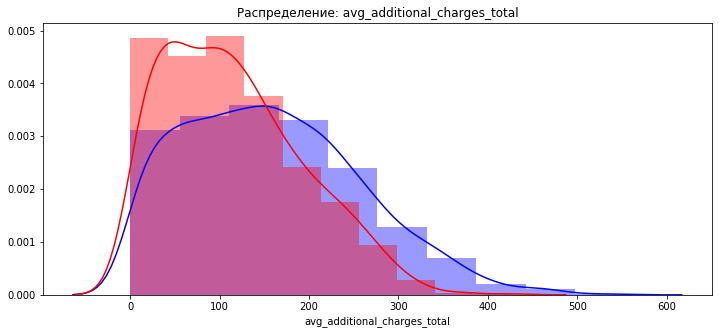

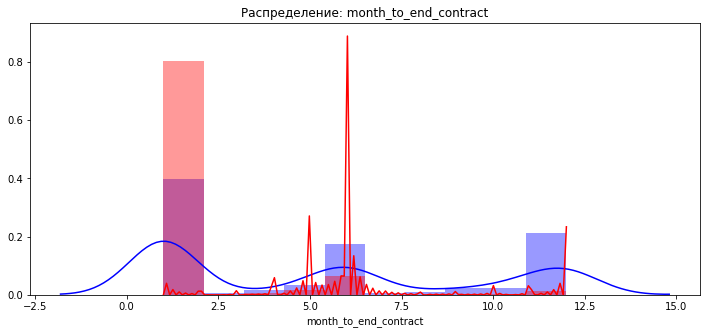

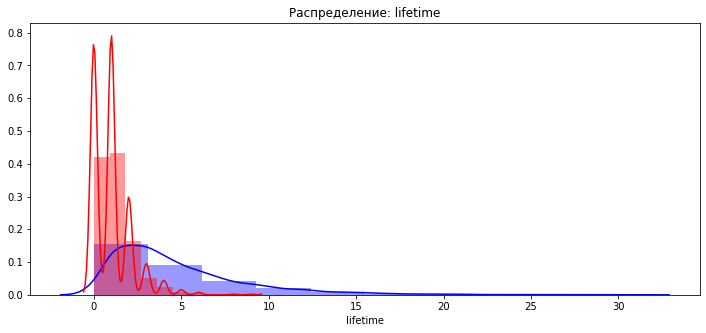

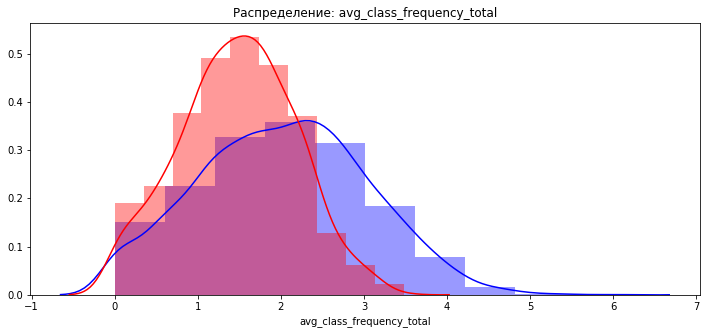

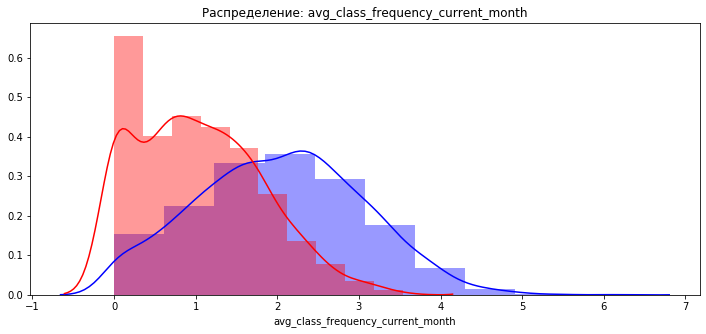

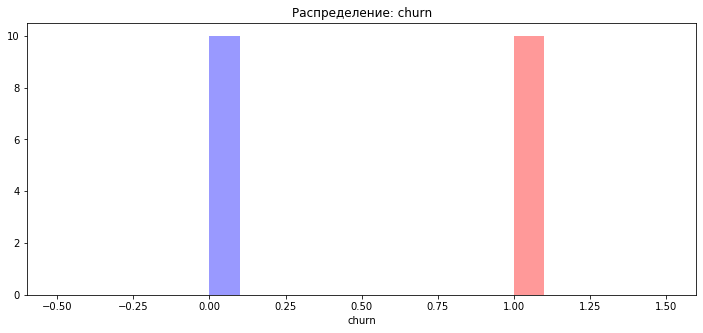

In [65]:
for column in gym_churn.columns:
    plt.figure(figsize=(12, 5))
    sns.distplot(gym_churn[gym_churn['churn']==0][column], bins=10, color='blue')
    sns.distplot(gym_churn[gym_churn['churn']==1][column], bins=10, color='red')
    plt.title(column)
    plt.title('Распределение: '+column)
    plt.show(); 

Плотность распределения  данных по ушедшим (красный) и активным (синий) клиентам на графиках выше показывает, что:
    - пол не влияет на отток;
    - те, кто проживает в ближайшей локации в меньшей степени покидают клуб;
    - участники партнёрских программ показывают меньший отток, чем те, кто пришел в клуб самостоятельно;
    - среди тех, кто ушёл из клуба реже всего встречаются предъявители промо-кода;
    - пользователи, что  оставляют свои телефонные номера, в равной степени покидают клуб, что и пользователи, не оставляющие контактные данные; 
    - длительность текущего действующего абонемента влияет на отток: среди тех, кто ушёл длительность абонемента составляля 1,7 месяца. Среди пользователей длительных абонементов отток наблюдается реже;
    - среди тех, кто покинул клуб реже всего встречаюся посетители групповых занятий;
    - более молодая аудитория демонстрирует больший отток; 
    - пользователи услуг, которые покинули клуб оплачивают дополнительные услуги менее интенсивно, чем те, кто остался клиентом клуба;
    - пользователи, у которых до конца контракта осталось в среднем 1,7 месяца более интенсивно покидают клуб;
    - также пользователи пришедшие в среднем месяц назад более склонны к тому, чтобы забросить занятия;
    - ушедшие пользователи посещают клуб с частотой в среднем 1 - 1,5 раза в неделю, тогда как среди тех, кто продолжил занятия частота посещений составила в среднем 2 раза в неделю. 
    

# Построение матрицы корреляций

In [66]:
cm = gym_churn.corr()

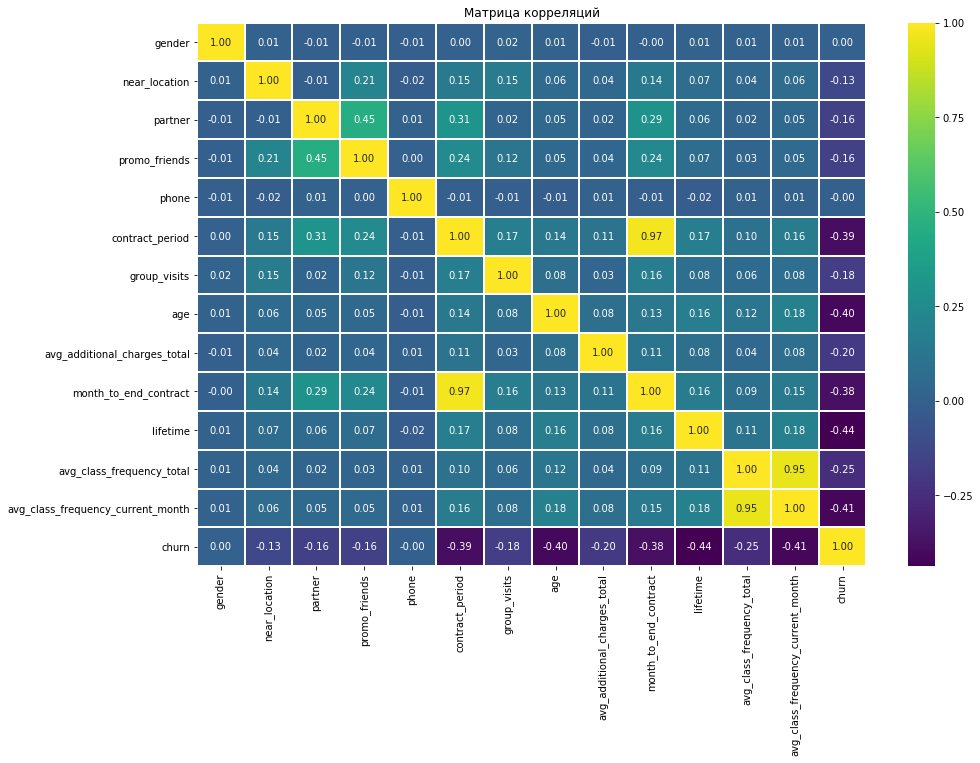

In [67]:
plt.figure(figsize=(15, 10))
plt.title('Матрица корреляций')
sns.heatmap(cm, annot=True, linewidths=1, fmt = '0.2f', cmap = 'viridis')
plt.show();

 Матрица корреляций показывает высокий коэффициент корреляции (0,97) для  month_to_end_contract и contract_period и эти признаки можно отнести к мультиколлинеарным, один из которых следует удалить во избежание ситуации переобучения при построении прогноза.  Также высокий коэффициент корреляции у avg_class_frequency_current_month и avg_class_frequency_total и это также мультиколлинеарные признаки. 
 
**Для целевой переменной:**
Обнаружена довольно значимая обратная зависимость у целевой переменной (отток - churn) и показателей lifetime (-0.44), avg_class_frequency_current_month (-0.41), age (-0.4), contract_period (-0.39), month_to_end_contract (-0.38). 
Показатели gender и phone показывают нулевую корреляцию и могут быть также удалены из прогнозов.

Также высокий коэффициент корреляции у  partner	 и promo_friends (0,45). Анализ позволяеет сделать вывод, что пользователи партнёрской программы  воспользовались промокодом в 52% случаев. Более того, можно утверждать, что лишь 216 пользователей услуг фитнес-клуба использовали промо-код, не являясь при этом участниками партнёрской программы:

In [68]:
gym_churn['partner'].sum() #абоненты по партнёрской программе

1947

In [69]:
gym_churn['promo_friends'].sum() #абоненты по промокоду

1234

In [70]:
promo_for_partners= gym_churn.query('partner == 1 & promo_friends ==1') #абоненты по партнёрской программе, использующие промо-код
promo_for_partners.shape

(1018, 14)

Соответственно, в данной ситуации мы можем отнести показатели partner и promo_friends к мультиколинеарным признакам.

# Выводы:

На основе анализа общих статитстических данных сделаны предварительные выводы:
   - зал посещает практически одинаковое количество женщин и мужчин;
   - большинство посетителей живут поблизости от фитнес-центра;
   - половина посетителей являются сотрудниками компаний-патрнеров;
   - только треть посетивших зал впервые воспользовались промо-кодом;
   - 90% пользователей оставили в анкетных данных свой телефон;
   - популярная длительность приобретаемого абонемента составляет 1 месяц;
   - пользователи посещают групповые занятия в 40% случаев;
   - возраст посетителей фитнес-клуба от 18 до 41 года, где и медианное и среднее значения  возраста  - 29 лет;
   - посетители чаще всего не выходят за рамки оплаченной абон.платы при принятии решения о покупке дополнительных услуг;
   - для фитнес-центра характерен очень короткий период lifiteme - времени с момента превого обращения: 1-3 месяца для большинства посетителей;
   - посетители посещают клуб 1-2 раза в неделю;
   - отток составляет 26%.
   
 Анализ показателей с учётом оттока показал:
   - пол не влияет на отток;
   - те, кто проживает в ближайшей локации в меньшей степени покидают клуб;
   - участники партнёрских программ показывают меньший отток, чем те, кто пришел в клуб самостоятельно;
   - среди тех, кто ушёл из клуба реже всего встречаются предъявители промо-кода;
   - пользователи, что  оставляют свои телефонные номера, в равной степени покидают клуб, что и пользователи, не оставляющие контактные данные; 
   - длительность текущего действующего абонемента влияет на отток: среди тех, кто ушёл длительность абонемента составляля 1,7 месяца. Среди пользователей длительных абонементов отток наблюдается реже;
   - среди тех, кто покинул клуб реже всего встречаюся посетители групповых занятий;
   - более молодая аудитория демонстрирует больший отток; 
   - пользователи услуг, которые покинули клуб оплачивают дополнительные услуги менее интенсивно, чем те, кто остался клиентом клуба;
   - пользователи, у которых до конца контракта осталось в среднем 1,7 месяца более интенсивно покидают клуб;
   - также пользователи пришедшие в среднем месяц назад более склонны к тому, чтобы забросить занятия;
   - ушедшие пользователи посещают клуб с частотой в среднем 1 - 1,5 раза в неделю, тогда как среди тех, кто продолжил занятия частота посещений составила в среднем 2 раза в неделю. 
   
Целевая пеерменная отток имеет довольно высокую обратную зависимость от показателей lifetime (-0.44), avg_class_frequency_current_month (-0.41), age (-0.4), contract_period (-0.39), month_to_end_contract (-0.38).

В процессе построения матрицы корреляций были определены мультиколинеарные признаки:  month_to_end_contract  и contract_period,  avg_class_frequency_current_month и avg_class_frequency_total, а также  partner и promo_friends. 

 [Вернуться к оглавлению](#шаг-0)

# Шаг 3. Построение модели прогнозирования оттока пользователей <a name="3"></a>

# Модель бинарной классификации

In [71]:
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

In [72]:
gym_churn['churn'].sum()/4000 #доля ответов "1"

0.26525

О балансе классов: accuracy может корректно работать при условии баланса классов. В нашем случае баланс классов отсутствует: доля ответов 1 значительно меньше доли ответов 0  и составляет 26,5%. 

# Логистическая регрессия

In [73]:
#разделяем модель на обучающую и валидационную выборку 20/80:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
model = LogisticRegression() #используем алгоритм логистической регрессии
model.fit(X_train, y_train) #обучаем модель

predictions = model.predict(X_test) #делаем с помощью обученной модели бинарный прогноз для объектов из валидац.данных
probabilities =  model.predict_proba(X_test)[:,1] #оценка вероятности принадлежности к классу "1" для валидац.данных 

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions))) #доля правильных ответов
print('Precision: {:.2f}'.format(precision_score(y_test, predictions))) #точность
print('Recall: {:.2f}'.format(recall_score(y_test, predictions))) # полнота
print('F1: {:.2f}'.format(f1_score(y_test, predictions))) #сводная метрика, учитывающая баланс между Precision и Recall

Accuracy: 0.93
Precision: 0.86
Recall: 0.83
F1: 0.85


# Случайный лес

In [74]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rfc_model = RandomForestClassifier(n_estimators = 100, random_state = 0) #100 деревьев, на основании которых строим лес
rfc_model.fit(X_train_st, y_train)
rfc_predictions = rfc_model.predict(X_test_st) 
rfc_probabilities = rfc_model.predict_proba(X_test_st)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rfc_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rfc_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rfc_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rfc_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


Мы прогнозируем более 90% ответов.  
Метрика precision говорит, 86% для "Логистической регрессии" и 84% для  модели "Случайный лес"  прогнозов относительно "1" класса верна.
Метрика recall показывает, что мы смогли обнаружить 83% (с помощью модели "Логистическая регрессия") и 81% (с помощью модели "Случайный лес") реальных объектов "1" класса. 
Чем ближе полученные значения к единице, тем лучше, и модель "Логистическая регрессия" выглядит в данном случае более привлекательной.

Теперь устраним эффект мультиколлинеарности. Также удалим из анализа показатели gender и phone, имеющие нулевую взаимосвязь с целевой переменной: 

In [75]:
X = gym_churn.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_total', 'promo_friends', 'gender', 'phone'], axis = 1)
y = gym_churn['churn']

# Логистическая регрессия без учёта мультиколлинеарности признаков

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=0) 
model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions))) #доля правильных ответов
print('Precision: {:.2f}'.format(precision_score(y_test, predictions))) #точность
print('Recall: {:.2f}'.format(recall_score(y_test, predictions))) # полнота
print('F1: {:.2f}'.format(f1_score(y_test, predictions))) #сводная метрика, учитывающая баланс между Precision и Recall

Accuracy: 0.90
Precision: 0.80
Recall: 0.81
F1: 0.80


# Случайный лес  без учёта мультиколлинеарности признаков

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rfc_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rfc_model.fit(X_train_st, y_train)
rfc_predictions = rfc_model.predict(X_test_st) 
rfc_probabilities = rfc_model.predict_proba(X_test_st)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rfc_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rfc_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rfc_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rfc_predictions)))

Accuracy: 0.89
Precision: 0.80
Recall: 0.76
F1: 0.78


# Выводы:

Устранение влияния мультиколлинеарных признаков на метрики показало худшие результаты, но всё ещё достаточно высокие. 
Здесь показатель Precision для модели "Случайный лес" равен (0,80), также как и для "Логистической регрессии" (0,80).
Recall для модели "Случайный лес" ниже (0,76), чем для "Логистической регрессии" (0,81). Предположим, что для нашей задачи Recall будет более значимой метрикой (пусть мы решим, что клиент уйдет и тревога будет ложной, чем мы ошибочно решим, что он останется). Поэтому "Логистичесая регрессия" выглядит более предпочтительной.

 [Вернуться к оглавлению](#шаг-0)

# Шаг 4. Кластеризация пользователей<a name="4"></a>

Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (пользователей):
•	Стандартизируйте данные.
•	Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.
•	Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).
•	Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
•	Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
•	Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?


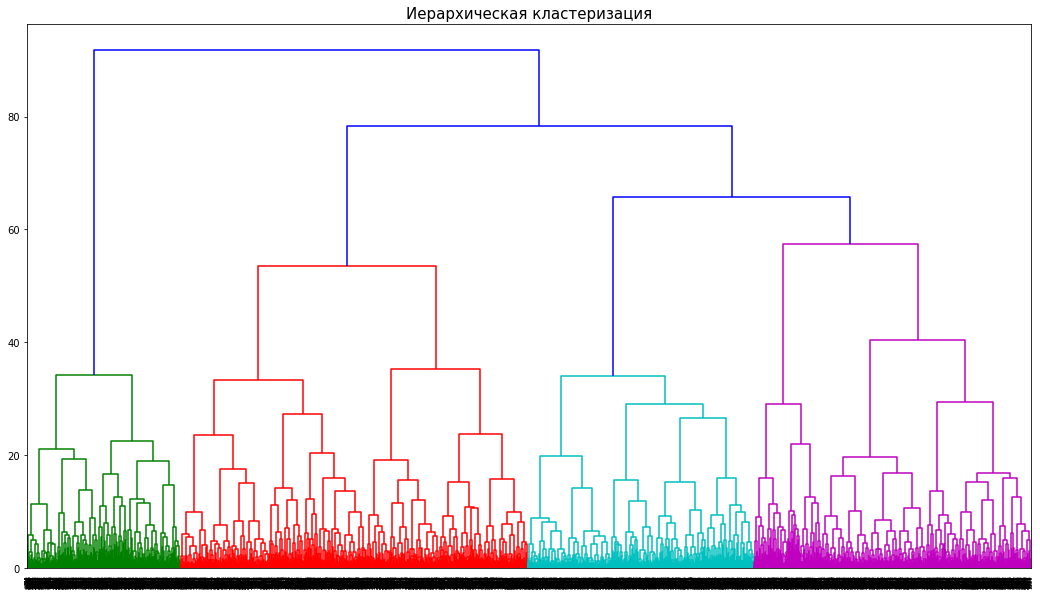

In [78]:
#стандартизируем данные:
sc = StandardScaler()
X_sc = sc.fit_transform(X) #данные не содержат 'month_to_end_contract', 'avg_class_frequency_total', 'promo_friends', 'gender', 'phone'

#строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков:
linked = linkage(X_sc, method='ward') 

#рисуем дендрограмму:
plt.figure(figsize=(18,10))
dendrogram(linked, orientation='top')
plt.title("Иерархическая кластеризация", fontsize = 15)
plt.show()

#обучаем модель кластеризации на основании алгоритма K-Means, задаём число кластеров равное 5 по условию:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_sc)

#создаём новый столбец
gym_churn['cluster'] = labels

In [79]:
#посчитаем метрику силуэта для оценки качества кластеризации:
silhouette = silhouette_score(X_sc, labels)
silhouette

0.16637497813635294

Значение метрики силуэта 0,16. Чем ближе к 1, тем качественнее кластеризация. Показатель довольно низкий - объект плохо сопоставляется с собственным кластером и хорошо сопоставляется с соседними кластерами, т.е. происходит перекрывание.

In [80]:
#считаем для каждого полученного кластера долю оттока:
clusters = gym_churn.groupby('cluster').mean().round(decimals=2)
clusters = np.transpose(clusters) 
display(clusters)

cluster,0,1,2,3,4
gender,0.50,0.50,0.55,0.53,0.50
near_location,0.99,1.00,0.96,1.00,0.00
partner,0.81,0.35,0.46,0.31,0.49
promo_friends,0.54,0.24,0.34,0.29,0.08
phone,0.91,0.90,0.88,0.90,0.91
contract_period,10.79,2.06,4.78,2.57,2.90
group_visits,0.53,0.00,0.45,1.00,0.22
age,30.14,28.34,30.23,29.18,28.67
avg_additional_charges_total,174.52,135.28,157.89,134.68,135.61
month_to_end_contract,9.76,1.99,4.39,2.45,2.75


# Построение распределения признаков для кластеров

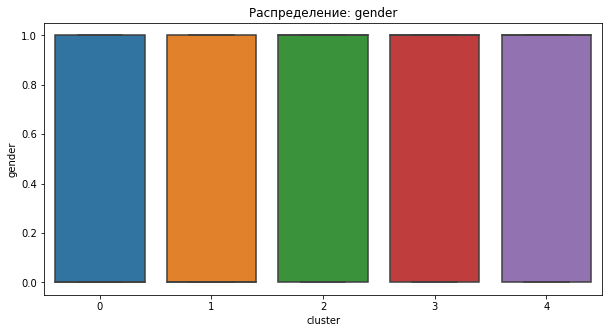

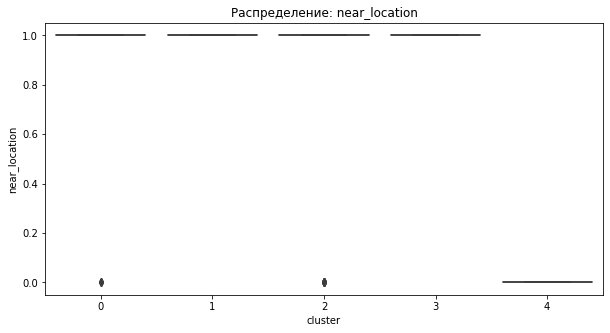

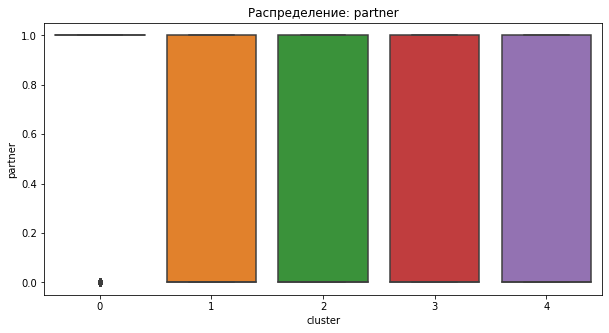

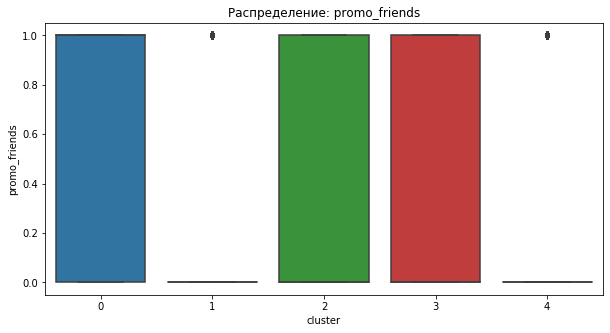

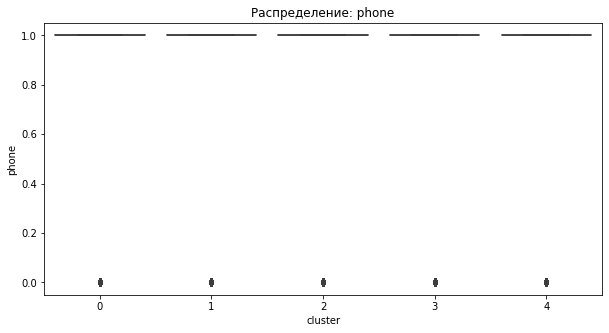

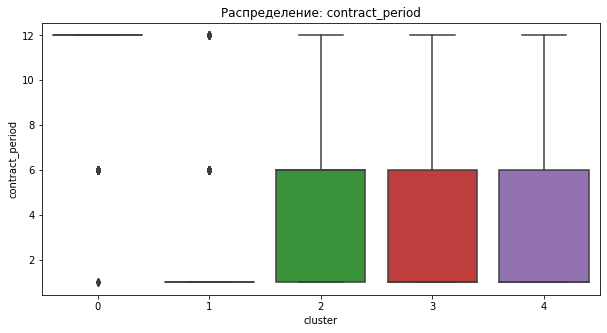

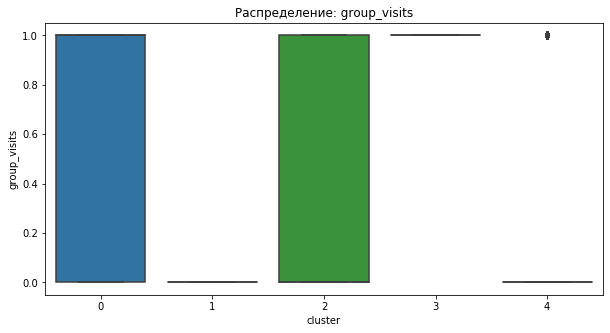

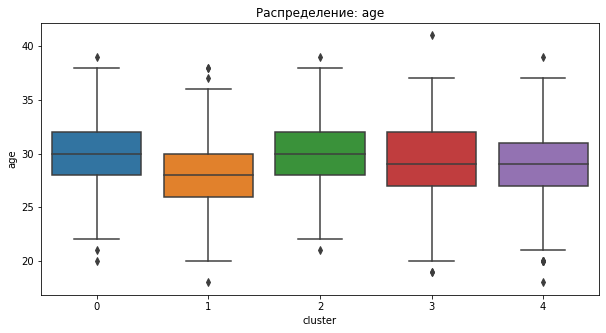

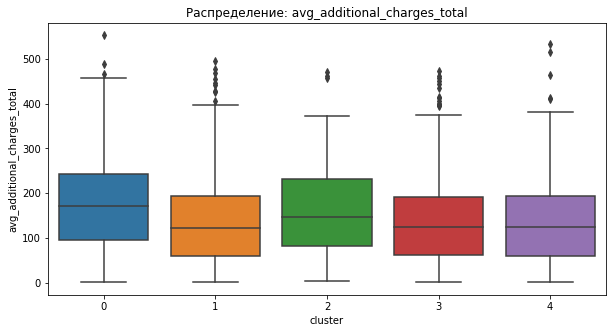

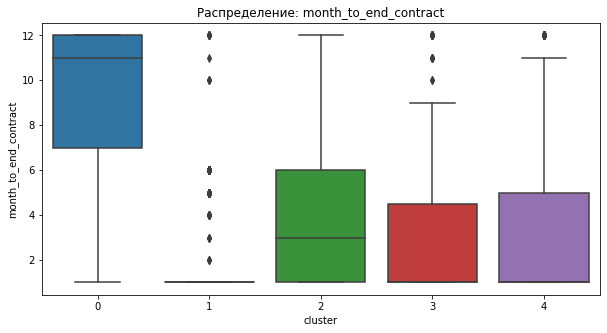

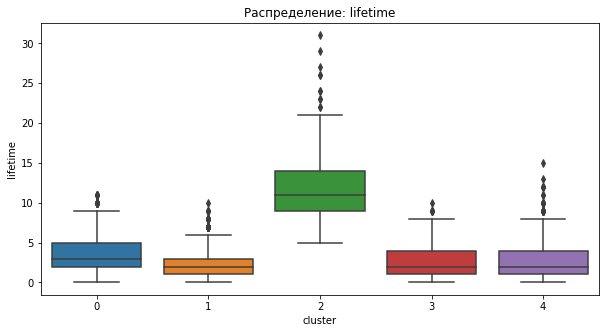

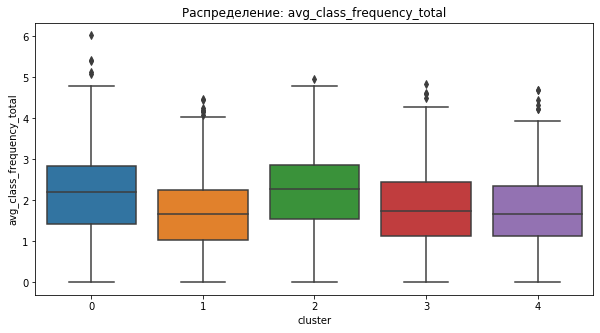

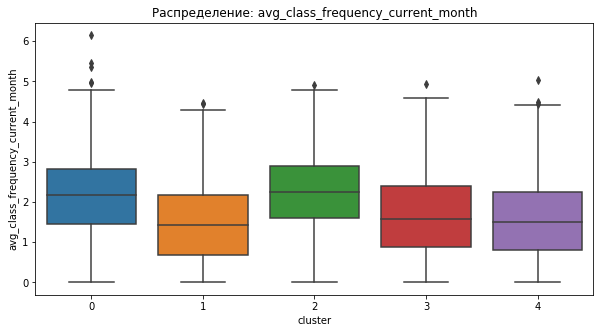

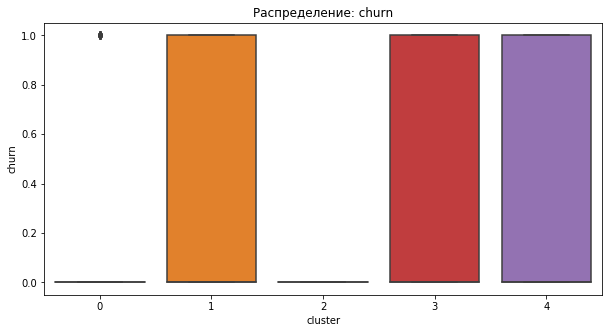

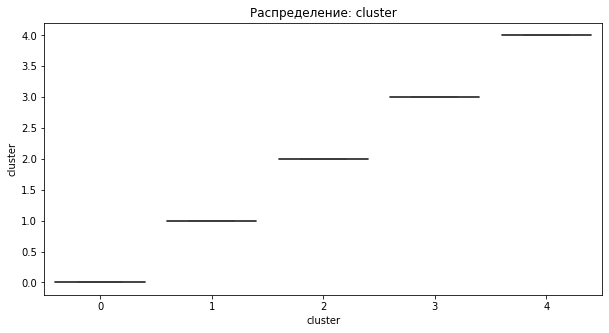

In [81]:
for column in gym_churn:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x = 'cluster', y = gym_churn[column], data=gym_churn)
    plt.title('Распределение: '+column)
    plt.show()

# Выводы:

**Общие характеристики:**
Наиболее устойчивые к оттоку кластеры характеризуются большей используемостью  промо-кодов, более высокой платежеспособностью за  дополнительные услуги и  более длительным абонементом. Также сюда можно отнести более старший возраст и более высокую частоту посещения клуба в неделю. 

Кластерам 1 и 4 характерен высокий уровень оттока 0,47 и 0,41 сооответственно:

**Первый кластер** включает пользователей услуг, живущих в ближайшей к клубу  локации,  период контракта в среднем для них составляет 2 месяца. Оплата дополнительных услуг составляет в среднем 135,3. Только треть пользователей посещает клуб по партнёрской программе.Они не посещают групповые занятия и это самый "молодой" кластер - в среднем возраст составляет 28,3 года. До завершения действия контракта у этих клиентов - в среднем  2 месяца. Среднее количество посещений в неделю - 1,5-1,7 раз.

**Четвёртый кластер** включает пользователей услуг, живущих в отдалении от клуба, половина этих пользователей являются членами партнёрской программы. Среди них очень мало пользователей, использовавших промо-код. Длительность абонемента для этих клиентов составляет в среднем 2,8 месяцев. Мнее четверти этих пользователей посещают групповые занятия. Средний возраст пользователей в составе кластера - 28,7 лет. Оплата дополнительных услуг составляет в среднем 135,6.

Нулевой и второй кластеры характеризуются практически нулевым показателем оттока:

**Нулевой кластер** характеризуется  пользователями, проживающими в ближайших районах. 80% посетителей являются членами партнёрских программ, активно использующие промо-коды. Длительность контракта высока - 10,8 месяцев. Половина пользователей посещает групповые программы. Средний возраст - 30,1. Этот кластер характеризуется максимальной средней суммой оплаты за доп.услуги в отношении других кластеров. Пользователи нулевого кластера посещают занятия в среднем 2,1 раза в неделю.

**Второй кластер** включает в себя пользователей, половина из которых участвуют в партнёрских программах, а треть участников 
использует промо-коды. кластер характеризуется достаточно длительным контрактом -  4,8 мес. Практически половина пользователей посещают групповые занятия. Средний возраст участников - 30,2. Оплата дополнительных услуг составляет в среднем 157,9. Для этого кластера характерен высокий показатель времени с момента первого обращения в месяцах - 12,1 мес. Частота посещения клуба в неделю  - 2,2 раза.

 [Вернуться к оглавлению](#шаг-0)

#  Шаг 5. Формулировка выводов и создание базовых рекомендаций по работе с клиентами<a name="5"></a>

# Общие выводы

Посетители фитнес-центра в наибольшей степени склонные  к уходу характеризуются следующими факторами:
в меньшей степени используют промо-коды, длительность контракта небольшая  - в среднем от 2 до 2,9 месяцев. Это более молодая аудитория, не склонная к дополнительным тратам на услуги, не включенные в абонемент. Также эти посетители значительно реже посещают групповые занятия и приходят в клубв среднем не чаще 1,5-1,8  раз в неделю. 

Наиболее устойчивые к оттоку кластеры характеризуются большей используемостью  промо-кодов, более высокой платежеспособностью за  дополнительные услуги и  более длительный абонемент. Также сюда можно отнести более старший возраст и более высокую частоту посещения клуба - более 2 раз в неделю. 

# Базовые рекомендации:

**Заключать более длительные контракты:**
Цель: увеличить среднюю длительность контракта с 4,6 месяцев до 8 месяцев
1) При приобретении длинного (годового) абонемента следует предлагать дополнительный месяц бесплатно.
2) Необходимо стимулировать клиентов к прибретению более длительных абонементов, например, включая некоторые дополнительные услуги в абонемент по принципу: "чем длительнее абонемент, тем большее количество дополнительных услуг будет включено".

**Не позволить абонентам уйти, не поборовшись за них:**
Цель: Сократить churn rate c 26% до 16%. 
1) Необходимо определить перечень клиентов чьи договоры истекают через несколько дней - в этот период пользователи принимают решение о продлении абонемента.
2) Провести более глубокий анализ churn rate на основе когортного анализа.
3) Сформировать персонифицированный пакет предложений для каждой полученной группы, в который войдут различные привелегии,например, возможность участия в еженедельной беспроигрышной лотерее, возможность приобретать дополнительные товары и услуги с большими скидками и т.д.
 
**Увеличить количество посещений в неделю:** *
Цель: на основе когортного анализа оценить текущий показатель  Retantion rate и увеличить его 
1) Стимулировать число посещений в неделю с помощью накопительной системы: при посещении клуба более четырёх раз в неделю клиент зарабатывает баллы, которые он в дальнейшем может использвать

*Примечание  - возможно, руководство не ставит такой задачи перед собой как увеличение числа посещений тренировок в неделю и заинтересовано только в увеличении длительности контракта с клиентом. Требуется уточнение и согласование с принятой стратегией компании.

**Увеличить число новых абонентов:**
Цель: Обеспечить новый приток абонентов на основе стратегии компании без увеличения затрат на привлечение клиентов
1) Для привлечения новых клиентов необходимо сосредоточиться на сегменте бизнес-партнёрства (B2B), учитывая, что именно такое сотрудничество чаще всего характеризуется более низкими затратами на привлечение. 
2) Следует обратить особое внимание программам по предоставлению промо-кодов: есть предположение, что эта программа не достаточно активно используется сейчас в фитнес-клубе и её ресурс не используется в полной мере.
3) Необходимо обратить внимание на потенциальных клиентах в возрасте 30+ лет, склонных к регулярным и частым посещениям фитнеса.
4) Необходимо стимулировать приобретение длительных абонементов  с включением групповых программ. Данные показывают, что клиенты, соответствующие этим требованиям с меньшей вероятностью уйдут.

**Определить, чем фитнес-центр привлекатеелн/непривлекателен для клиентов:**
Цель: Оценка зон роста фитнес-центра и выявление сильных строн для дальнейшего их развития. Следует выяснить в чём причина высокого оттока  с учетом принадлежности клиентов к различным кластерам. 
1) Необходимо провести анкетирование среди посетителей. Возможно, что причина оттока окажется банальной: грубость и равнодушие персонала, старые полотенца, несвоевременная уборка или некомфортные шкафчики и душевые кабинки. 

 [Вернуться к оглавлению](#шаг-0)